In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
import pickle
from dateutil.parser import parse
import datetime
from dateutil.parser import parse
import math
from numpy import mean

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline as SKLpipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC 
from sklearn.tree import export_text
import dtreeviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import umap

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBLpipeline

from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import warnings

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import ipynbname
notebook_name = ipynbname.name()

import seaborn as sns

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 35)

2023-06-05 17:42:32.493254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define directory path name and timestamp

# Get the current date and time as a string
timestamp = datetime.datetime.now().strftime('%d%m%Y_%H%M')

# Construct the directory path with the models folder and timestamp
dir_path = f"models/{timestamp}"
    
# Create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [3]:
# Saving models

# Function to save best estimator
def save_best_estimator(grid_search_cv, classifier_name, notebook_name):
    # Get the best estimator from the GridSearchCV object
    best_estimator = grid_search_cv.best_estimator_

    # Construct the file name with the classifier name and notebook name
    pickle_file_name = f"{dir_path}/{classifier_name}-{notebook_name}-{timestamp}.pkl"
    
    # Save the best estimator to the file
    with open(pickle_file_name, 'wb') as f:
        pickle.dump(best_estimator, f)

    print(f"Best estimator saved as: {pickle_file_name}")

In [4]:
# Function for loading saved models

def load_best_estimator(pickle_file_name):
    with open(pickle_file_name, 'rb') as f:
        best_estimator = pickle.load(f)
    return best_estimator

In [5]:
# import data
X = pd.read_csv("data/data splits/X_train.csv")
y = np.genfromtxt("data/data splits/y_train.csv", delimiter=',', skip_header=1, dtype=int)
X_all = pd.read_csv("data/data splits/X_all.csv")
y_all = np.genfromtxt("data/data splits/y_all.csv", delimiter=',', skip_header=1, dtype=int)
X_eval = pd.read_csv("data/data splits/X_test.csv")
y_eval = np.genfromtxt("data/data splits/y_test.csv", delimiter=',', skip_header=1, dtype=int)

--------

# Modelling

In [6]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE()), 
    ('under', RandomUnderSampler()), 
    ('clf', DecisionTreeClassifier())
])

parameters = {
            # 'clf__max_depth': [2,3,4],
            # 'clf__min_samples_split': [5, 10, 15, 20],
            'clf__min_samples_leaf': [60, 80, 100], 
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
            # 'clf__max_leaf_nodes': [5, 7, 10],
            # 'clf__ccp_alpha': [0.2, 0.3, 0.4],
               'clf__class_weight': ['balanced', None],
               'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
               'under__sampling_strategy': [0.5, 0.6, 0.7],
               'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv_dt = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True),
                    return_train_score=False, 
                    verbose=1, 
                    refit="f1",
                    n_jobs=-1)
resultsGSCV = gscv_dt.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_dt, classifier_name, notebook_name)

# Save best parameters 
DT_best_params = gscv_dt.best_params_
df = pd.DataFrame([DT_best_params])
df.to_csv(f"{dir_path}/DT_best_params-{notebook_name}-{timestamp}.csv", index=False)
# Save with pickle
with open(f"{dir_path}/DT_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(DT_best_params, f)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best estimator saved as: models/05062023_1742/DecisionTreeClassifier-HAB_modelling_6_8-DT-visualisation_2-05062023_1742.pkl


,457,358,337,447,417,278,346,421,331,338,339,350,327,419,465,341,431,...,369,306,65,146,475,317,137,218,56,398,479,297,378,460,308,380,459
mean_fit_time,0.019301,0.019376,0.019495,0.019611,0.020165,0.024157,0.018667,0.020665,0.018604,0.017879,0.019737,0.024894,0.019367,0.018966,0.019705,0.01988,0.020053,...,0.018161,0.018887,0.018355,0.017851,0.018294,0.017549,0.018901,0.038906,0.01948,0.019452,0.013931,0.019031,0.019272,0.017655,0.018512,0.018136,0.018126
std_fit_time,0.000459,0.001443,0.001238,0.000876,0.001658,0.002054,0.000542,0.001447,0.000256,0.000646,0.000988,0.007083,0.001346,0.000813,0.000981,0.001191,0.001041,...,0.000673,0.001563,0.000875,0.000929,0.001662,0.000661,0.001855,0.017498,0.001011,0.001798,0.003426,0.002314,0.001476,0.000379,0.000895,0.002214,0.000293
mean_score_time,0.012249,0.011443,0.011685,0.01182,0.012187,0.014726,0.012427,0.012331,0.011268,0.011116,0.010863,0.013614,0.012581,0.012256,0.011428,0.011553,0.012265,...,0.012256,0.012526,0.010739,0.011139,0.010794,0.012657,0.01108,0.022672,0.012083,0.011973,0.008726,0.013384,0.013025,0.012118,0.011878,0.01215,0.012375
std_score_time,0.001035,0.000507,0.0007,0.00046,0.001736,0.001418,0.000893,0.000749,0.000194,0.000393,0.001009,0.003769,0.001559,0.000674,0.000272,0.000265,0.000915,...,0.000888,0.001225,0.001789,0.000781,0.002389,0.002485,0.000259,0.011453,0.000537,0.000983,0.002549,0.002002,0.002207,0.000452,0.000826,0.002131,0.000848
param_clf__class_weight,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,balanced,balanced,None,None,balanced,balanced,balanced,None,None,None,None,None,None,None,None
param_clf__criterion,log_loss,entropy,entropy,log_loss,log_loss,gini,entropy,log_loss,entropy,entropy,entropy,entropy,entropy,log_loss,log_loss,entropy,log_loss,...,entropy,gini,gini,entropy,log_loss,gini,entropy,log_loss,gini,entropy,log_loss,gini,entropy,log_loss,gini,entropy,log_loss
param_clf__min_samples_leaf,80,80,60,80,60,80,60,60,60,60,60,60,60,60,100,60,60,...,80,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
param_smt__k_neighbors,5,1,3,3,3,1,5,3,1,3,3,5,1,3,1,3,5,...,5,3,3,3,3,5,1,1,1,5,5,1,1,1,3,1,1
param_smt__sampling_strategy,0.4,0.4,0.3,0.4,0.3,0.4,0.3,0.4,0.4,0.3,0.4,0.4,0.3,0.3,0.4,0.4,0.4,...,0.2,0.2,0.2,0.2,0.4,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
param_under__sampling_strategy,0.6,0.6,0.6,0.5,0.5,0.7,0.6,0.6,0.6,0.7,0.5,0.7,0.5,0.7,0.5,0.7,0.7,...,0.5,0.5,0.7,0.7,0.6,0.7,0.7,0.7,0.7,0.7,0.7,0.5,0.5,0.6,0.7,0.7,0.5


In [7]:
# Evaluation on test data
dt_clf = gscv_dt.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/12042023_1718/DecisionTreeClassifier-HAB_modelling_5_8-12042023_1718.pkl"
# dt_clf = load_best_estimator(pickle_file_name).steps[2][1]

y_pred = dt_clf.predict(X_eval)
DT_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
DT_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.93      0.85      0.89       224
         poz       0.43      0.62      0.51        40

    accuracy                           0.82       264
   macro avg       0.68      0.74      0.70       264
weighted avg       0.85      0.82      0.83       264



X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


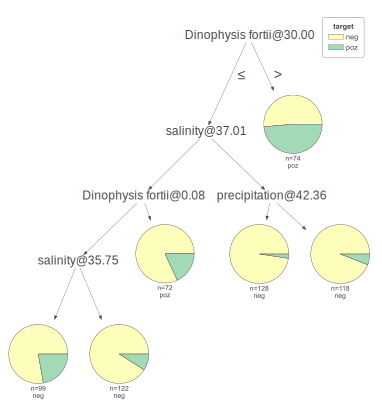

In [8]:
viz_model = dtreeviz.model(dt_clf, X, y,
                target_name="target",
                feature_names=X.columns,
                class_names=["neg", "poz"]
             #   scale=1.5
              )

# Save the visualization as a PNG file
viz_file_name = f"{dir_path}/DT_visualisation.svg"
# viz_model.save(viz_file_name)
v = viz_model.view(fancy=False)    
# v.save(viz_file_name) 
# print(f"Visualization saved as: {viz_file_name}")

# Display the visualization
v

--------------

## Retrain DT with best parameters from gridsearch on a all data

In [9]:
import random
# Generate a random number between 0 and 10000
rand_num = random.randint(0, 10000)
# rand_num = None

#save random state number
with open(f"{dir_path}/random_state_number-{notebook_name}-{timestamp}.txt", 'w') as f:
    f.write(str(rand_num))
print(rand_num)

6473


In [10]:
# Retrain DT with best parameters from gridsearch on a all data
best_params = gscv_dt.best_params_

# # Load the data with pickle
# with open('DT_best_params.pkl', 'rb') as f:
#     DT_best_params = pickle.load(f)

print(best_params)

# Create a pipeline with the best parameters
best_pipeline = IMBLpipeline([
    ('smt', SMOTE(sampling_strategy=best_params['smt__sampling_strategy'], k_neighbors=best_params['smt__k_neighbors'], random_state=rand_num)), 
    ('under', RandomUnderSampler(sampling_strategy=best_params['under__sampling_strategy'], random_state=rand_num)), 
    ('clf', DecisionTreeClassifier(min_samples_leaf=best_params['clf__min_samples_leaf'], criterion=best_params['clf__criterion'], class_weight=best_params['clf__class_weight'], random_state=rand_num))
])

# Train the model on the entire dataset
best_pipeline.fit(X_all, y_all)

# Save resampled data
X_resampled, y_resampled = best_pipeline.named_steps['smt'].fit_resample(X_all, y_all)
X_resampled, y_resampled = best_pipeline.named_steps['under'].fit_resample(X_resampled, y_resampled)

# Extract the decision tree classifier from the pipeline
best_dt_clf = best_pipeline.named_steps['clf']

# Save the best decision tree classifier with pickle
with open(f"{dir_path}/best_DT_clf_all_data.pkl-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(best_dt_clf, f)

{'clf__class_weight': None, 'clf__criterion': 'log_loss', 'clf__min_samples_leaf': 80, 'smt__k_neighbors': 5, 'smt__sampling_strategy': 0.4, 'under__sampling_strategy': 0.6}


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Visualization saved as: models/05062023_1742/DT_visualisation.svg


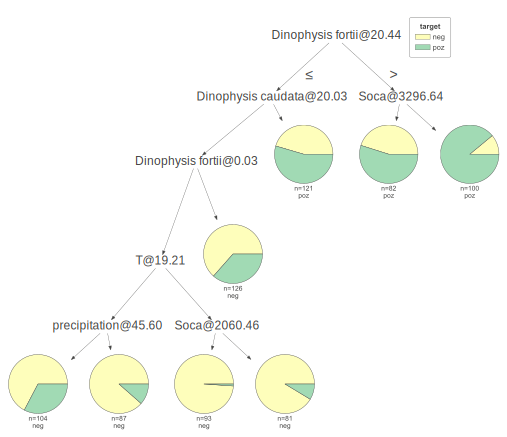

In [11]:
#Visualise DT
viz_model = dtreeviz.model(best_dt_clf, X_resampled, y_resampled,
                target_name="target",
                feature_names=X_resampled.columns,
                class_names=["neg", "poz"]
             #   scale=1.5
              )

# Save the visualization as a PNG file
viz_file_name = f"{dir_path}/DT_visualisation.svg"
v = viz_model.view(fancy=False)    
v.save(viz_file_name) 

print(f"Visualization saved as: {viz_file_name}")

# Display the visualization
v



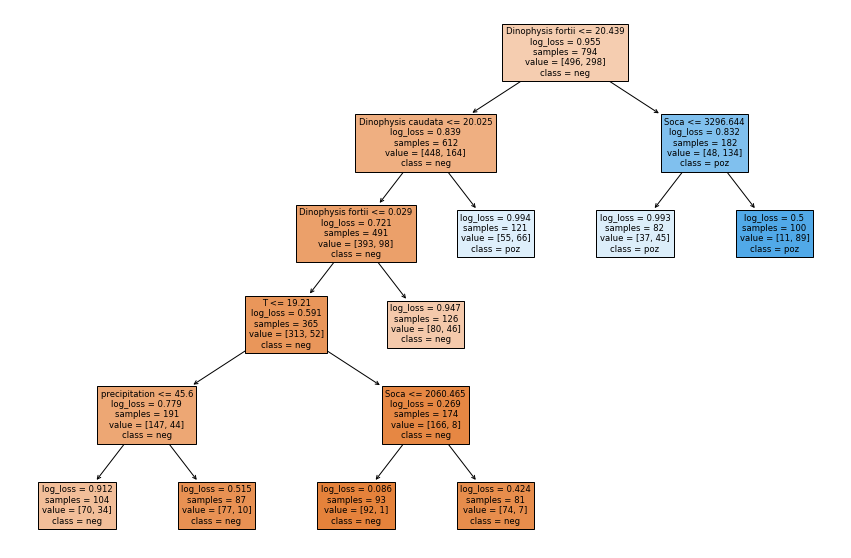

In [12]:
from sklearn import tree
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(best_dt_clf, 
                   feature_names=X_all.columns,  
                   class_names=["neg", "poz"],
                   filled=True)

-----------

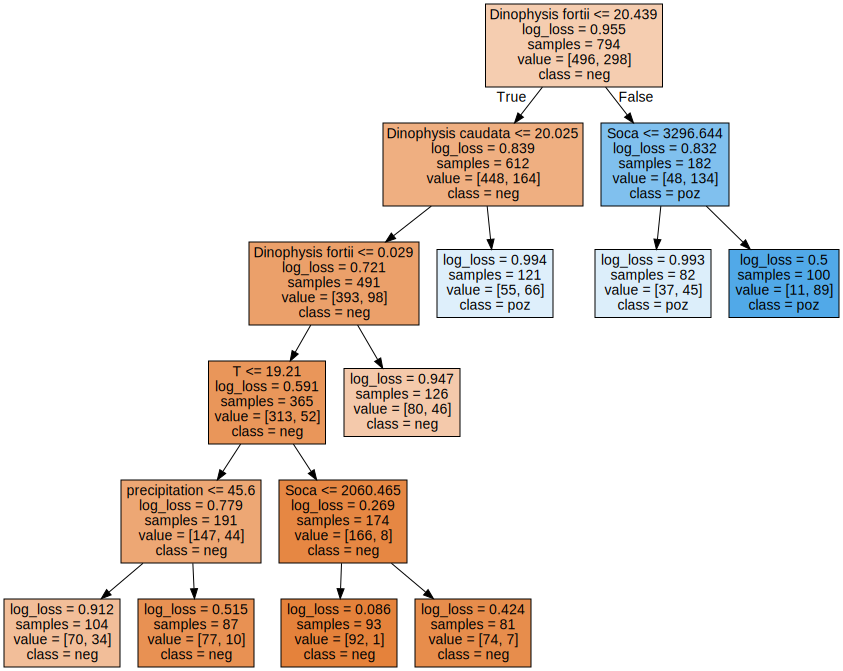

In [13]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(best_dt_clf, out_file=None, 
                                feature_names=X_all.columns,  
                                class_names=["neg", "poz"],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph